In [11]:
!pip install tensorflow opencv-python matplotlib tensorflow-gpu==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import the google drive location

In [12]:
from google.colab import drive
g_drive = drive.mount("/content/drive/", force_remount=True)


Mounted at /content/drive/


Import all required modules for the module

In [13]:
import tensorflow as tf
import os

In [14]:
# Avoid Out Of Memory (OOM) errors by setting GPU Memory Consumption
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


In [15]:
import cv2
import imghdr

In [16]:
data_dir = "/content/drive/MyDrive/colabContainer/Data/testing"

In [17]:
image_exts = ["jpeg", "jpg", "bmp", "png"]

Cleaning the image store to only get applicable images

In [18]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print(f"Invalid image type: {tip}, Path: {image_path}")
        os.remove(image_path)
    except Exception as e:
      print(f"Error with image {e}")
      


In [19]:
import numpy as np
from matplotlib import pyplot as plt

The command below will bring up the documentation stating what pre-processing the method will run

In [20]:
tf.keras.utils.image_dataset_from_directory??

In [21]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 305 files belonging to 2 classes.


In [22]:
data_iterator = data.as_numpy_iterator()

In [23]:
# Images represented as np arrays
batch = data_iterator.next()

# Image loaded into memory as np array
batch[0] 


array([[[[2.11000000e+02, 2.00000000e+02, 1.68000000e+02],
         [2.11000000e+02, 2.00000000e+02, 1.68000000e+02],
         [2.11000000e+02, 2.00000000e+02, 1.68000000e+02],
         ...,
         [2.18000000e+02, 2.12000000e+02, 1.90000000e+02],
         [2.18000000e+02, 2.12000000e+02, 1.90000000e+02],
         [2.18000000e+02, 2.12000000e+02, 1.90000000e+02]],

        [[2.11000000e+02, 2.00000000e+02, 1.68000000e+02],
         [2.11000000e+02, 2.00000000e+02, 1.68000000e+02],
         [2.11000000e+02, 2.00000000e+02, 1.68000000e+02],
         ...,
         [2.18000000e+02, 2.12000000e+02, 1.90000000e+02],
         [2.18000000e+02, 2.12000000e+02, 1.90000000e+02],
         [2.18000000e+02, 2.12000000e+02, 1.90000000e+02]],

        [[2.11000000e+02, 2.00000000e+02, 1.68000000e+02],
         [2.11000000e+02, 2.00000000e+02, 1.68000000e+02],
         [2.11000000e+02, 2.00000000e+02, 1.68000000e+02],
         ...,
         [2.18000000e+02, 2.12000000e+02, 1.90000000e+02],
         [

Class labels:

*  0 = Happy People
*  1 = Sad People

In [24]:
# Labels
batch[1]

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0], dtype=int32)

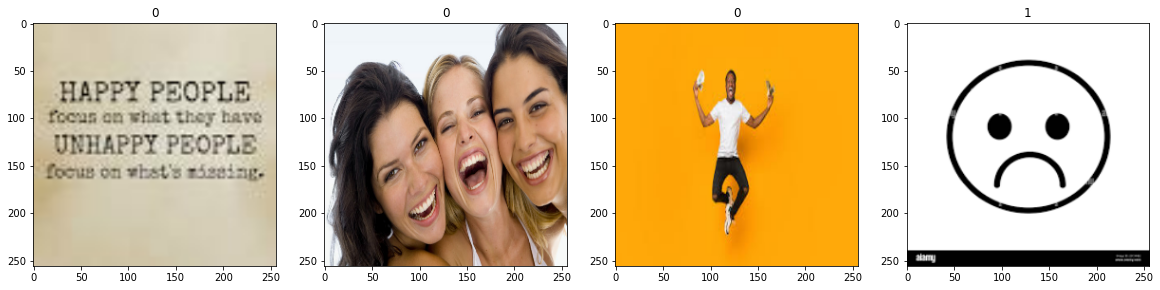

In [25]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

# Preprocessing Data

Here we will be changing the images from 255, 255 to 0 & 1

Only run if Data output is not a max() of 1.0 and a min() of 0.0 when running the code belwo this commane. If not then run this command.

In [26]:
#data = tf.keras.utils.image_dataset_from_directory(data_dir, shuffle=False)
#data = tf.keras.utils.image_dataset_from_directory(data_dir)

Manually shuffling the data removes a bug within the `.take()` method that comes later.

In [27]:
#data = data.shuffle(1000, seed=100, reshuffle_each_iteration=False)

In [28]:
data = data.map(lambda image, label: (image/255, label))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [29]:
scaled_iterator = data.as_numpy_iterator()

In [30]:
batch = scaled_iterator.next()

Test the batch

In [31]:
batch[0].min()

0.0

In [32]:
batch[0].max()

1.0

# Split Data 

In [33]:
len(data)
train_size = int(len(data)*0.7) # 70% of the data
val_size = int(len(data)*0.2) # 20% of the data
test_size = int(len(data)*0.1) # 10% of the data

In [34]:
print(f"{len(data)}, {train_size}, {val_size}, {test_size}")

10, 7, 2, 1


In [35]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [36]:
len(train)

7

# Modelling
Building the Deep Learning Model

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [38]:
model = Sequential()

In [39]:
model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))


In [40]:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# Train The Model

In [42]:
log_dir = "/content/drive/MyDrive/colabContainer/Logs"
log_dir

'/content/drive/MyDrive/colabContainer/Logs'

In [43]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [44]:
history = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 28s 3s/step - loss: 0.8339 - accuracy: 0.5312 - val_loss: 0.7113 - val_accuracy: 0.4531
Epoch 2/20
7/7 [==============================] - 24s 3s/step - loss: 0.6578 - accuracy: 0.5848 - val_loss: 0.6233 - val_accuracy: 0.8281
Epoch 3/20
7/7 [==============================] - 29s 4s/step - loss: 0.6040 - accuracy: 0.7143 - val_loss: 0.4940 - val_accuracy: 0.7656
Epoch 4/20
7/7 [==============================] - 24s 3s/step - loss: 0.5611 - accuracy: 0.7545 - val_loss: 0.6561 - val_accuracy: 0.6406
Epoch 5/20
7/7 [==============================] - 25s 3s/step - loss: 0.5356 - accuracy: 0.7411 - val_loss: 0.4269 - val_accuracy: 0.8750
Epoch 6/20
7/7 [==============================] - 24s 3s/step - loss: 0.4204 - accuracy: 0.8482 - val_loss: 0.3232 - val_accuracy: 0.8906
Epoch 7/20
7/7 [==============================] - 24s 3s/step - loss: 0.3372 - accuracy: 0.8527 - val_loss: 0.2836 - val_accuracy: 0.8906
Epoch 8/20
7/7 [==================

## Plot performance

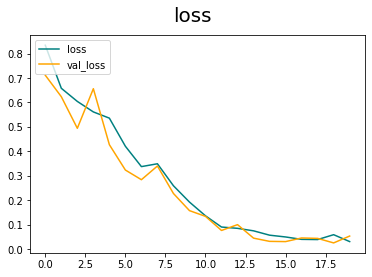

In [45]:
fig = plt.figure()
plt.plot(history.history["loss"], color="teal", label="loss")
plt.plot(history.history["val_loss"], color="orange", label="val_loss")
fig.suptitle("loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

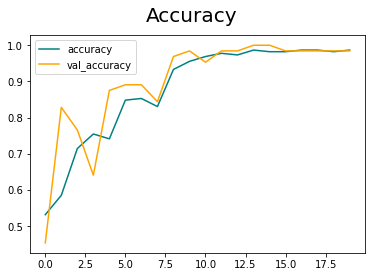

In [46]:
fig = plt.figure()
plt.plot(history.history["accuracy"], color="teal", label="accuracy")
plt.plot(history.history["val_accuracy"], color="orange", label="val_accuracy")
fig.suptitle("Accuracy", fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate Performance

In [47]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [48]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [49]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 1s 767ms/step


In [50]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [51]:
print(f"Actual {y} predict {yhat}")

Actual [0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1] predict [[1.54905513e-06]
 [9.99940276e-01]
 [8.85080755e-01]
 [6.92470407e-04]
 [1.08357039e-04]
 [5.60360568e-05]
 [7.71083772e-01]
 [9.99473155e-01]
 [9.90074337e-01]
 [9.07507896e-01]
 [7.81124516e-04]
 [1.46153005e-04]
 [1.05129376e-01]
 [1.21692700e-08]
 [8.95714939e-01]
 [3.35888617e-04]
 [9.84816790e-01]]


# Test

In [64]:
img = cv2.imread("/content/drive/MyDrive/colabContainer/Data/8iAb9k4aT.jpg")

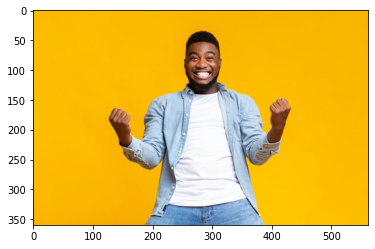

In [53]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

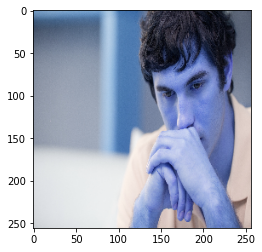

In [65]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))

In [66]:
yhat = model.predict(np.expand_dims(resize/255, 0))

if yhat > 0.5:
  print("Prediction: Sad")
  print(f"Score: {yhat}")
else:
  print("Prediction: Happy")
  print(f"Score: {yhat}")


1/1 [==============================] - 0s 41ms/step
Prediction: Sad
Score: [[0.98221004]]


In [57]:
yhat

array([[0.04934178]], dtype=float32)

# Save The Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
save_loc = "/content/drive/MyDrive/colabContainer/Models/happySadModel"

model.save(save_loc)

In [ ]:
new_model = load_model(save_loc)

Now you can use your model to make predictions using the code similar to the final test code.